# Flames - Extended Feature Selection
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 14, 2022

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model. This notebook will test the standard StellarAlgo retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 36 # flames
cursor = CNXN.cursor()

storedProc = (
    f"""Exec ds.customerScores {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(38816, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38816 entries, 0 to 38815
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            38816 non-null  int64  
 1   dimCustomerMasterId     38816 non-null  int64  
 2   customerNumber          38816 non-null  object 
 3   year                    38816 non-null  int64  
 4   productGrouping         38816 non-null  object 
 5   totalSpent              38816 non-null  float64
 6   recentDate              38816 non-null  object 
 7   attendancePercent       38816 non-null  float64
 8   renewedBeforeDays       38815 non-null  float64
 9   isBuyer                 38816 non-null  object 
 10  source_tenure           38816 non-null  int64  
 11  tenure                  38815 non-null  float64
 12  distToVenue             38816 non-null  float64
 13  totalGames              38816 non-null  int64  
 14  recency                 38816 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "clickToOpenRatio", 
    "clickToSendRatio",
    "distToVenue",
    "inperson_contact",
    "isNextYear_Buyer",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "openToSendRatio",
    "productGrouping",
    "recency",
    "renewedBeforeDays",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (28573, 17)
Unseen Data For Predictions: (5042, 17)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
    "clickToOpenRatio", 
    "clickToSendRatio",
    "distToVenue",
    "inperson_contact",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "openToSendRatio",
    "recency",
    "renewedBeforeDays",
    "source_tenure",
    "totalSpent"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9117,0.9330,0.9724,0.9077,0.9389,0.7805,0.7866,0.8160
lr,Logistic Regression,0.7145,0.7671,0.9610,0.7226,0.8242,0.1336,0.1995,0.3040


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9160,0.9404,0.9699,0.9149,0.9416,0.7927,0.7970
1,0.9201,0.9397,0.9805,0.9117,0.9449,0.8008,0.8078
2,0.9127,0.9334,0.9740,0.9076,0.9397,0.7826,0.7890
3,0.9016,0.9282,0.9687,0.8982,0.9321,0.7543,0.7614
4,0.9111,0.9283,0.9693,0.9092,0.9383,0.7798,0.7849
5,0.9049,0.9282,0.9717,0.8999,0.9344,0.7623,0.7698
6,0.9156,0.9353,0.9705,0.9138,0.9413,0.7916,0.7962
7,0.9057,0.9280,0.9705,0.9018,0.9349,0.7647,0.7715
8,0.9106,0.9242,0.9758,0.9038,0.9384,0.7765,0.7841
9,0.9189,0.9447,0.9728,0.9161,0.9436,0.7995,0.8041


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(5201, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
33615,36,980,14590697,2021,Mini Plan,1598.88,2021-11-27,1.000000,17.0,TRUE,...,0,0,0.0,1,44,2,0,0,0.9972,0.0028
33616,36,3135,124553,2021,Full Season,3917.43,2022-01-18,0.769231,28.0,TRUE,...,0,0,0.0,1,44,2,0,1,0.1089,0.8911
33617,36,3349,119724,2021,Full Season,12419.88,2022-01-18,1.000000,28.0,TRUE,...,0,0,0.0,1,44,2,0,1,0.1686,0.8314
33618,36,3464,131901,2021,Full Season,12419.88,2022-01-18,0.692308,98.0,TRUE,...,0,0,0.0,1,44,2,0,0,0.7010,0.2990
33619,36,5016,133815,2021,Half Season,4988.16,2021-12-11,0.857143,40.0,TRUE,...,0,0,0.0,1,44,2,0,1,0.4277,0.5723


In [11]:
new_predictions["Label"].value_counts()

1    2895
0    2306
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.6, 0.8]       1348
(-0.001, 0.2]    1042
(0.4, 0.6]       1000
(0.8, 1.0]        999
(0.2, 0.4]        812
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

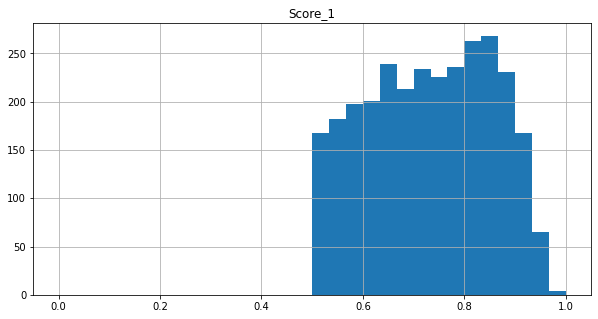

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

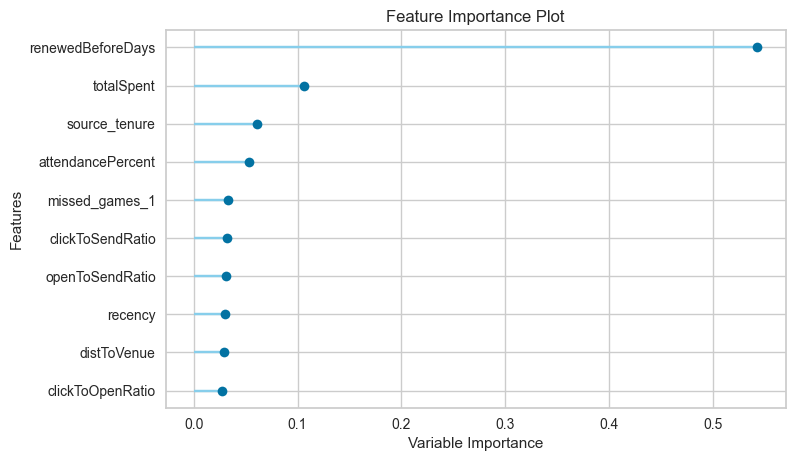

In [14]:
plot_model(best_model, plot='feature')

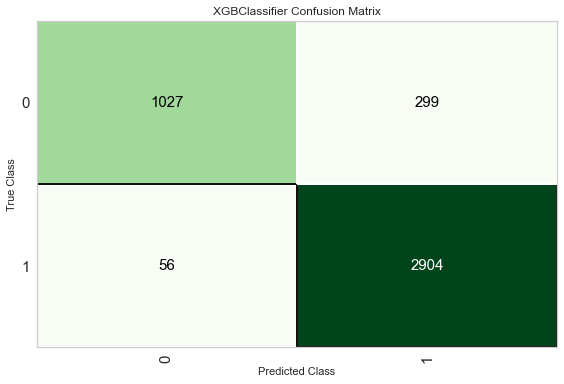

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?